In [146]:
import pImpactR as impact
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from copy import deepcopy as copy
from scipy.optimize import minimize
import shutil 
import pickle
rectangular_ = 1
elliptic_ = 2

In [2]:
NL_t = 0.4
emitGeomRMS = 3.3e-6
npt = 1000000
print('npt=',npt)
nturn = 10000

npt= 1000000


In [3]:
NL_L = 1.8
NL_c = 0.01
NL_nu = 0.3

# read Aperture

In [4]:
aperture = np.loadtxt('pipeinfo.in')

In [5]:
aperture[-1,0]

39.968229720000004

In [6]:
ap0_x,ap0_y = 0.00680513, 0.00935705
ap1_x,ap1_y = 4.00000000e-03, 5.50000000e-03
ang = np.arange(0.0,2*np.pi,2*np.pi/1024)
c = np.cos(ang)
s = np.sin(ang)

# read impact lattice

In [7]:
beam,lattice = impact.readInputFile('test.Chad.in')
beam.nCore_y=8
beam.nCore_z=4
beam.n_particles = npt

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

g = ke/mass+1.0
bg = np.sqrt(g**2-1.0)
emitN = emitGeomRMS*bg
print('\n\n emitN =',emitN)

reading ImpactZ input file (test.Chad.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


 emitN = 2.4105916749973357e-07


In [8]:
cleanLat = impact.clearLattice(lattice)
L = 0 
for item in cleanLat:
    if item.type == 'RFkick':
        item.vmax = 0.0
    if item.type == 'nonlinear_insert':
        NLfoward = item
        print('NL:',L,L+item.length)
    if 'length' in item:
        L = L+item.length
print(L-aperture[-1,0])

NLfoward.n_sckick = 2
NLfoward.n_map = 45

NL: 4.9115191429 6.711519142899999
-4.199918635094946e-09


In [9]:
NLfoward


             length: 1.8 [m]
           n_sckick: 2 [1]
              n_map: 45 [1]
         strength_t: 0.4
 transverse_scale_c: 0.01
        pipe_radius: 10.0 [m]
       tune_advance: 0.3
               type: 'nonlinear_insert'

In [10]:
for item in cleanLat:
    if 'length' in item:
        item.n_sckick = int(np.ceil(item.length*50))
        item.n_map = 1

add quadrupole fringe hard-edge model

In [11]:
cleanLat = impact.addHardEdgeQuad(cleanLat)

# Back tracking for IOTA matched beam at injection location

In [12]:
for i in range(len(cleanLat)):
    if cleanLat[i].type == 'nonlinear_insert':
        break

latticeB = impact.getInverseLattice(cleanLat[:i])

write0 = impact.getElem('write_raw_ptcl')
write0.file_id = 111110
write0.format_id = 2
latticeB.insert(0,write0)


write1 = impact.getElem('write_raw_ptcl')
write1.file_id = 111111
write1.format_id = 2
latticeB.append(write1)

loop = impact.getElem('loop')
loop.turns = 1
latticeB.insert(0,loop)

In [13]:
cleanLat.insert(0,impact.getElem('pipeinfo'))
cleanLat.insert(1,impact.getElem('loop'))
cleanLat[1].turns = nturn

write2 = impact.getElem('write_raw_ptcl')
write2.file_id = 222222
write2.format_id = 2
cleanLat.append(write2)

# Define runs

### thermal

In [14]:
def prepareIOTA_Thermal(tauBeam,tauMag,H0,dE,order,CL):
    beam.distribution.mode = 'twiss'
    beam.distribution.distribution_type = 'IOTA_Gauss'
    beam.distribution.NL_t  = tauBeam
    beam.distribution.NL_c  = NL_c
    beam.distribution.betx  = NL_L/np.sin(2.0*np.pi*NL_nu)
    beam.distribution.alfx  = np.tan(np.pi*NL_nu)
    beam.distribution.emitx = H0
    beam.distribution.CL    = CL
    beam.distribution.betz  = 200
    beam.distribution.alfz  = 0.0
    beam.distribution.emitz = (dE*ke*1.0e-6)**2*beam.distribution.betz
    impact.writeInputFile(beam,latticeB)
    impact.writeInputFile(beam,latticeB,'test.in.prepare.nonlinearThermal.tau='+str(tauBeam))
    impact.run(beam,order=order)
    pData0 = impact.readParticleData(111110,ke,mass,freq,2)
    Twiss0 = impact.getTwiss_from_pData(pData0)
    pData0 = pData0[:,[0,1,2,3,5,-1]]
    pData1 = impact.readParticleData(111111,ke,mass,freq,2)
    Twiss1 = impact.getTwiss_from_pData(pData1)
    pData1 = pData1[:,[0,1,2,3,5,-1]]
    
    beam.distribution.distribution_type = 'ReadFile_binary'
    beam.distribution.file_id = 111111
    NLfoward.strength_t = tauMag
    impact.writeInputFile(beam,cleanLat,'test.in.run.tau='+str(tauBeam))
    
    shutil.copyfile('fort.111110', 'fort.NL_ent.thermal.npt='+str(npt)+'.NL_t='+str(tauMag)+'.beam_t='+str(tauBeam)+'.turn=0')
    shutil.copyfile('fort.111111', 'fort.inject.thermal.npt='+str(npt)+'.NL_t='+str(tauMag)+'.beam_t='+str(tauBeam)+'.turn=0')
    
    return Twiss0,Twiss1,pData0,pData1

In [15]:
def runIOTA_Thermal(t0,t1,tauBeam,tauMag,order):
    
    shutil.copyfile('fort.inject.thermal'+
                    '.npt='+str(npt)+
                    '.NL_t='+str(tauMag)+
                    '.beam_t='+str(tauBeam)+
                    '.turn='+str(t0),
                    'fort.111111')
    
    beam.distribution.distribution_type = 'ReadFile_binary'
    beam.distribution.file_id = 111111
    NLfoward.strength_t = tauMag
    cleanLat[1].turns = t1-t0
    write2.turn = t1-t0
    impact.writeInputFile(beam,cleanLat)
    impact.run(beam,order=order)
    
    try:
        pLost = np.loadtxt('lost_partcl.data',skiprows=1, usecols=(0,1,2,3))
        print(len(pLost))
    except:
        pLost = 0
        
    fname = 'lost_partcl.pickle.thermal'+   \
            '.NL_t='+str(tauMag)+    \
            '.beam_t='+str(tauBeam)+ \
            '.t0='+str(t0)+          \
            '.t1='+str(t1)
    pickle.dump(pLost,open(fname,'wb'))
    
    
    shutil.copyfile('fort.222222', 
                    'fort.inject.thermal'+
                    '.npt='+str(npt)+
                    '.NL_t='+str(tauMag)+
                    '.beam_t='+str(tauBeam)+
                    '.turn='+str(t1))
    
    emitx = np.loadtxt('fort.24',usecols=(0, -1))
    s = emitx[:,0]
    emitx = emitx[:,-1]
    emity = np.loadtxt('fort.25',usecols=(-1))
    fort81 = np.loadtxt('fort.81',usecols=(1,2,3,4,5))
    Hmean = fort81[:,0]
    Imean = fort81[:,1]
    Hstd  = fort81[:,2]
    Istd  = fort81[:,3]
    HIcor = fort81[:,4]
    stat = {'s':s,
           'emitx':emitx,
           'emity':emity,
           'Hmean':Hmean,
           'Imean':Imean,
           'Hstd' :Hstd,
           'Istd' :Istd,
           'HIcor':HIcor}
    fname = 'stat.pickle.thermal'+   \
            '.NL_t='+str(tauMag)+    \
            '.beam_t='+str(tauBeam)+ \
            '.t0='+str(t0)+          \
            '.t1='+str(t1)
    pickle.dump(stat,open(fname,'wb'))
    
    return 0

In [16]:
def getIOTA_Thermal_data(T,tauBeam,tauMag):
    '''
    T=[t0,t1,t2...tn]
    '''
    shutil.copyfile('fort.NL_ent.thermal.npt='+str(npt)+'.NL_t='+str(tauMag)+'.beam_t='+str(tauBeam)+'.turn=0',
                    'fort.111110')
    shutil.copyfile('fort.inject.thermal.npt='+str(npt)+'.NL_t='+str(tauMag)+'.beam_t='+str(tauBeam)+'.turn=0',
                    'fort.111111')
    
    pData0 = impact.readParticleData(111110,ke,mass,freq,2)
    Twiss0 = impact.getTwiss_from_pData(pData0)
    pData0 = pData0[:,[0,1,2,3,5,-1]]
    pData1 = impact.readParticleData(111111,ke,mass,freq,2)
    Twiss1 = impact.getTwiss_from_pData(pData1)
    pData1 = pData1[:,[0,1,2,3,5,-1]]
    
    
    
    Ltot = []
    Stats ={'s':[],
            'emitx':[],
            'emity':[],
            'Hmean':[],
            'Imean':[],
            'Hstd' :[],
            'Istd' :[],
            'HIcor':[]}
    for i in range(len(T)-1):
        t0 = T[i]
        t1 = T[i+1]
        fname = 'stat.pickle.thermal'+   \
                '.NL_t='+str(tauMag)+    \
                '.beam_t='+str(tauBeam)+ \
                '.t0='+str(t0)+          \
                '.t1='+str(t1)
        print(fname)
        tmp = pickle.load(open(fname,'rb'))
        if i>0:
            tmp['s'] = tmp['s']+Ltot[-1]
        for key in Stats.keys():
            Stats[key] = Stats[key] + list(tmp[key])
        Ltot.append(Stats['s'][-1])
        
    for key in Stats.keys():
        Stats[key] = np.array(Stats[key])
   

    
    
    pLostList = []
    nptLost = []
    n = 0
    for i in range(len(T)-1):
        t0 = T[i]
        t1 = T[i+1]
        fname = 'lost_partcl.pickle.thermal'+   \
                '.NL_t='+str(tauMag)+    \
                '.beam_t='+str(tauBeam)+ \
                '.t0='+str(t0)+          \
                '.t1='+str(t1)
        print(fname)
        tmp = pickle.load(open(fname,'rb'))
        if not isinstance(tmp,int):
            if i>0:
                tmp[:,0]=tmp[:,0]+Ltot[i-1]
            nptLost.append(len(tmp))
            pLostList.append(copy(tmp))
        if len(nptLost)>1:
            nptLost[-1]=nptLost[-2]+nptLost[-1]
    
    pLost = np.zeros([nptLost[-1],4])
    pLost[:nptLost[0],:]=pLostList[0]
    for i in range(1,len(pLostList)):
        pLost[nptLost[i-1]:nptLost[i],:]=pLostList[i]
    
        
    return {'Twiss0':Twiss0,'Twiss1':Twiss1,'pData0':pData0,'pData1':pData1,'pLost':pLost,'Stats':Stats}

### Exponential

In [17]:
def prepare_Exponential(betx,alfx,emitx,CLx,bety,alfy,emity,CLy,dE,tauBeam,tauMag,order):
    beam.distribution.mode = 'twiss'
    beam.distribution.distribution_type = 'Exponential2D_trunc'
    beam.distribution.betx  = betx
    beam.distribution.alfx  = alfx
    beam.distribution.emitx = emitx
    beam.distribution.CLx   = CLx
    beam.distribution.bety  = bety
    beam.distribution.alfy  = alfy
    beam.distribution.emity = emity
    beam.distribution.CLy   = CLy
    beam.distribution.betz  = 200
    beam.distribution.alfz  = 0.0
    beam.distribution.emitz = (dE*ke*1.0e-6)**2*beam.distribution.betz
    
    impact.writeInputFile(beam,cleanLat[:2]+[write1])
    impact.run(beam,order=order)

    shutil.copyfile('fort.111111', 'fort.inject.exponential'+
                                   '.npt='+str(npt)+
                                   '.NL_t='+str(tauMag)+
                                   '.beam_t='+str(tauBeam)+'.turn0')

    return 0

In [18]:
def run_Exponential(t0,t1,tauBeam,tauMag,order):
    
    shutil.copyfile('fort.inject.exponential'+
                    '.npt='+str(npt)+
                    '.NL_t='+str(tauMag)+
                    '.beam_t='+str(tauBeam)+
                    '.turn='+str(t0),
                    'fort.111111')
    
    beam.distribution.distribution_type = 'ReadFile_binary'
    beam.distribution.file_id = 111111
    NLfoward.strength_t = tauMag
    cleanLat[1].turns = t1-t0
    write2.turn = t1-t0
    impact.writeInputFile(beam,cleanLat)
    impact.run(beam,order=order)
    
    try:
        pLost = np.loadtxt('lost_partcl.data',skiprows=1, usecols=(0,1,2,3))
        print(len(pLost))
    except:
        pLost = 0
        
    fname = 'lost_partcl.pickle.exponential'+   \
            '.NL_t='+str(tauMag)+    \
            '.beam_t='+str(tauBeam)+ \
            '.t0='+str(t0)+          \
            '.t1='+str(t1)
    pickle.dump(pLost,open(fname,'wb'))
    
    
    shutil.copyfile('fort.222222', 
                    'fort.inject.exponential'+
                    '.npt='+str(npt)+
                    '.NL_t='+str(tauMag)+
                    '.beam_t='+str(tauBeam)+
                    '.turn='+str(t1))
    
    emitx = np.loadtxt('fort.24',usecols=(0, -1))
    s = emitx[:,0]
    emitx = emitx[:,-1]
    emity = np.loadtxt('fort.25',usecols=(-1))
    fort81 = np.loadtxt('fort.81',usecols=(1,2,3,4,5))
    Hmean = fort81[:,0]
    Imean = fort81[:,1]
    Hstd  = fort81[:,2]
    Istd  = fort81[:,3]
    HIcor = fort81[:,4]
    stat = {'s':s,
           'emitx':emitx,
           'emity':emity,
           'Hmean':Hmean,
           'Imean':Imean,
           'Hstd' :Hstd,
           'Istd' :Istd,
           'HIcor':HIcor}
    fname = 'stat.pickle.exponential'+   \
            '.NL_t='+str(tauMag)+    \
            '.beam_t='+str(tauBeam)+ \
            '.t0='+str(t0)+          \
            '.t1='+str(t1)
    pickle.dump(stat,open(fname,'wb'))
    
    return 0

In [19]:
def get_Exponential_data(T,tauBeam,tauMag):
    '''
    T=[t0,t1,t2...tn]
    '''
    shutil.copyfile('fort.inject.exponential.npt='+str(npt)+'.NL_t='+str(tauMag)+'.beam_t='+str(tauBeam)+'.turn=0',
                    'fort.111111')
    
    pData1 = impact.readParticleData(111111,ke,mass,freq,2)
    Twiss1 = impact.getTwiss_from_pData(pData1)
    pData1 = pData1[:,[0,1,2,3,5,-1]]
    
       
    Ltot = []
    Stats ={'s':[],
            'emitx':[],
            'emity':[],
            'Hmean':[],
            'Imean':[],
            'Hstd' :[],
            'Istd' :[],
            'HIcor':[]}
    for i in range(len(T)-1):
        t0 = T[i]
        t1 = T[i+1]
        fname = 'stat.pickle.exponential'+   \
                '.NL_t='+str(tauMag)+    \
                '.beam_t='+str(tauBeam)+ \
                '.t0='+str(t0)+          \
                '.t1='+str(t1)
        print(fname)
        tmp = pickle.load(open(fname,'rb'))
        if i>0:
            tmp['s'] = tmp['s']+Ltot[-1]
        for key in Stats.keys():
            Stats[key] = Stats[key] + list(tmp[key])
        Ltot.append(Stats['s'][-1])
        
    for key in Stats.keys():
        Stats[key] = np.array(Stats[key])
   

    
    
    pLostList = []
    nptLost = []
    n = 0
    for i in range(len(T)-1):
        t0 = T[i]
        t1 = T[i+1]
        fname = 'lost_partcl.pickle.exponential'+   \
                '.NL_t='+str(tauMag)+    \
                '.beam_t='+str(tauBeam)+ \
                '.t0='+str(t0)+          \
                '.t1='+str(t1)
        print(fname)
        tmp = pickle.load(open(fname,'rb'))
        if not isinstance(tmp,int):
            if i>0:
                tmp[:,0]=tmp[:,0]+Ltot[i-1]
            nptLost.append(len(tmp))
            pLostList.append(copy(tmp))
        if len(nptLost)>1:
            nptLost[-1]=nptLost[-2]+nptLost[-1]
    
    pLost = np.zeros([nptLost[-1],4])
    pLost[:nptLost[0],:]=pLostList[0]
    for i in range(1,len(pLostList)):
        pLost[nptLost[i-1]:nptLost[i],:]=pLostList[i]
    
        
    return {'Twiss1':Twiss1,'pData1':pData1,'pLost':pLost,'Stats':Stats}

# Run and collect data

In [ ]:
# lostp_data = {}
import pickle
# pickle.dump(lostp_data,open('lostp_data.QFF.p100000.pickle','wb'))
# lostp_data = pickle.load(open('lostp_data.QFF.p100000.pickle','rb'))

### Thermal, $H_{\tau=0.4}$, $\sigma_E=2\times10^{-3}$, $order=3$

In [ ]:
# Twiss0,Twiss1,pData0,pData1 = prepareIOTA_Thermal(0.4,0.4,emitGeomRMS,2.0e-3,3,6.0)

In [ ]:
# runIOTA_Thermal(0,10000,0.4,0.4,3)

In [22]:
data = getIOTA_Thermal_data([0,10000],0.4,0.4)

stat.pickle.thermal.NL_t=0.4.beam_t=0.4.t0=0.t1=10000
lost_partcl.pickle.thermal.NL_t=0.4.beam_t=0.4.t0=0.t1=10000


In [366]:
deco = 'plot.thermal.NL_t=0.4.beam_t=0.4.npt=1000000.nturn=10000'

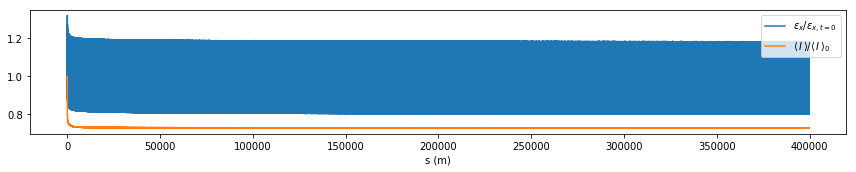

In [363]:
plt.figure(figsize=(12,2.5))

plt.plot(data['Stats']['s'],data['Stats']['emitx']/data['Stats']['emitx'][0])
plt.plot(data['Stats']['s'],data['Stats']['emity']/data['Stats']['emity'][0])
# plt.yscale('log')
plt.xlabel('s (m)')
plt.legend([r'$\epsilon_x/\epsilon_{x,t=0}$',r'$\epsilon_y/\epsilon_{y,t=0}$'])
plt.tight_layout()
plt.savefig()

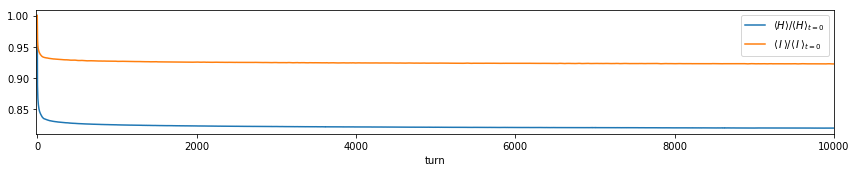

In [365]:
plt.figure(figsize=(12,2.5))

plt.plot(data['Stats']['Hmean']/data['Stats']['Hmean'][0])
plt.plot(data['Stats']['Imean']/data['Stats']['Imean'][0])
# plt.yscale('log')
plt.xlabel('turn')
plt.xlim(-10,10000)
plt.legend([r'$\langle H \rangle/\langle H \rangle_{t=0}$',r'$\langle\, I\, \rangle/\langle\, I\, \rangle_{t=0}$'])
plt.tight_layout()

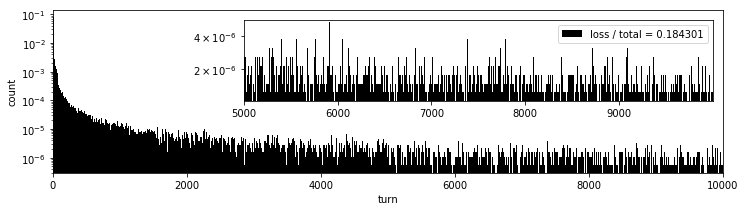

In [307]:
nlost = len(data['pLost'][:,0])
# plt.hist(data['pLost'][:,0]/L,bins=1000,range=(0,10000),color='b',alpha=0.5)
plt.figure(figsize=(12,3))
ax = plt.subplot(1,1,1)
plt.hist(data['pLost'][:,0]/L,bins=1000,range=(0,10000),color='k',density=True)
plt.xlim([0,10000])
# plt.ylim([0,100])
plt.yscale('log')
plt.xlabel('turn');
plt.ylabel('count');

inset_axes2 = inset_axes(ax,
                         width="70%", # width = 30% of parent_bbox
                         height="50%", # height : 1 inch
                         loc=1,
                         borderpad=1)
inset_axes2.hist(data['pLost'][:,0]/L,bins=1000,range=(0,10000),color='k',density=True)
# inset_axes2.grid()
inset_axes2.set_xlim([5000,10000])
inset_axes2.set_ylim([0,5e-6])
inset_axes2.set_xticks([5000,6000,7000,8000,9000])
# inset_axes2.set_yticks([0,2e-6,4e-6,6e-6,8e-6],['0','2e-6','4e-6','6e-6','8e-6'])
inset_axes2.set_yticks([2e-6,4e-6])
inset_axes2.set_yticklabels([r'$2\times10^{-6}$',r'$4\times10^{-6}$'])
inset_axes2.legend(['loss / total = '+str(nlost/1e6)])
# inset_axes2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# mark_inset(ax, inset_axes2, loc1=2, loc2=4)#, fc="none", ec="0.5")

In [25]:
data.keys()

dict_keys(['Twiss0', 'Twiss1', 'pData0', 'pData1', 'pLost', 'Stats'])

In [26]:
def cdf(x):
    return 0.5*(1.0+np.erf(x/np.sqrt(2)))

def get20percent(x):
    return (cdf(x) - 0.2)**2

def get40percent(x):
    return (cdf(x) - 0.4)**2

def get60percent(x):
    return (cdf(x) - 0.6)**2

def get80percent(x):
    return (cdf(x) - 0.8)**2


X=[minimize(get20percent,-0.08).x,minimize(get40percent,-0.02).x,minimize(get60percent,0.02).x,minimize(get80percent,0.08).x]
X

[array([-0.8416186]),
 array([-0.25334682]),
 array([0.2533468]),
 array([0.84161858])]

In [27]:
X20 = -2.0e-3 * X[0]
X40 = -2.0e-3 * X[1]

In [28]:
pDataIndex = [data['pData1'][:,4]/2.5e6 < -X20,
              data['pData1'][:,4]/2.5e6 < -X40,
              data['pData1'][:,4]/2.5e6 <  X40,
              data['pData1'][:,4]/2.5e6 <  X20,]

pDataIndex = [pDataIndex[0],
              pDataIndex[1] * (-X20 <= data['pData1'][:,4]/2.5e6),
              pDataIndex[2] * (-X40 <= data['pData1'][:,4]/2.5e6),
              pDataIndex[3] * ( X40 <= data['pData1'][:,4]/2.5e6),
                                X20 <= data['pData1'][:,4]/2.5e6 ]
    
Index = [data['pData0'][pDataIndex[i],-1] for i in range(5)]

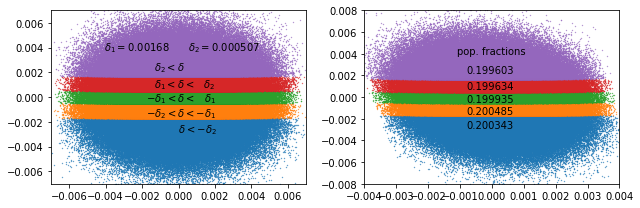

In [346]:
NPT = []
for i in range(5):
    NPT.append(len(Index[i]))
    
plt.figure(figsize=(9,3))    
plt.subplot(1,2,1)
for i in range(5):
    plt.scatter(data['pData0'][pDataIndex[i],0],data['pData0'][pDataIndex[i],4]/2.5e6,s=0.1)
plt.xlim(-0.007,0.007)
plt.ylim(-0.007,0.007)
plt.text(-0.0041,  0.0038,r'$\delta_1=0.00168 $');
plt.text( 0.0005,  0.0038,r'$\delta_2=0.000507$');
plt.text(-0.0018, .00219 ,r'$\,\,\,\,\,\delta_2 < \delta$');
plt.text(-0.0018, .000752,r'$\,\,\,\,\,\delta_1 < \delta < \,\,\,\,\,\delta_2$');
plt.text(-0.0018,-.000387,r'$-\delta_1 < \delta < \,\,\,\,\,\delta_1$');
plt.text(-0.0018,-.001548,r'$-\delta_2 < \delta < -\delta_1$');
plt.text(-0.0018,-.00283 ,r'$\qquad\quad\,\, \delta < -\delta_2$');

plt.subplot(1,2,2)
for i in range(5):
    plt.scatter(data['pData1'][pDataIndex[i],0],data['pData1'][pDataIndex[i],4]/2.5e6,s=0.1)
    plt.scatter(1,1,color='C'+str(i))
plt.xlim(-0.004,0.004)
plt.ylim(-0.008,0.008)
plt.text(-0.0011, .004 ,'pop. fractions')
plt.text(-0.0008, .00217 ,NPT[4]/1e6)
plt.text(-0.0008, .00074 ,NPT[3]/1e6);
plt.text(-0.0008,-.000429,NPT[2]/1e6);
plt.text(-0.0008,-.001548,NPT[1]/1e6);
plt.text(-0.0008,-.00287 ,NPT[0]/1e6);
plt.tight_layout()

In [65]:
X20,X40

(array([0.00168324]), array([0.00050669]))

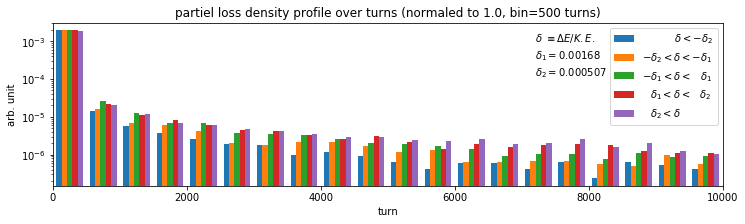

In [215]:
plt.figure(figsize=(12,3))
bins = 20
turns= 10000
npt  = 1e6
# yticks = np.array([10,100,1000,10000,100000])/2
yticks_per_turn = yticks/npt/(turns/bins)
plt.hist([data['pLost'][pLostIndex[i],0]/L for i in range(5)],bins=20,range=(0,10000),density=True);
plt.yscale('log')
plt.xlabel('turn')
plt.ylabel('arb. unit')
plt.title('partiel loss density profile over turns (normaled to 1.0, bin=500 turns)')
plt.legend(['$\qquad\quad\,\, \delta < -\delta_2$',
            '$-\delta_2 < \delta < -\delta_1$',
            '$-\delta_1 < \delta < \,\,\,\,\,\delta_1$',
            '$\,\,\,\,\,\delta_1 < \delta < \,\,\,\,\,\delta_2$',
            '$\,\,\,\,\,\delta_2 < \delta$']);
plt.xlim(0,10000)
plt.text(7200,1.0e-3,r'$\delta\,\,\equiv \Delta E/K.E.$');
plt.text(7200,3.4e-4,r'$\delta_1=0.00168 $');
plt.text(7200,1.2e-4,r'$\delta_2=0.000507$');
# plt.yticks(yticks,yticks_per_turn);

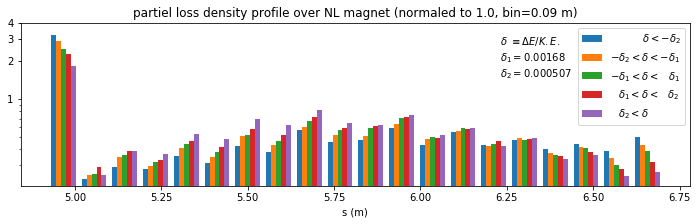

In [223]:
plt.figure(figsize=(12,3))
ax = plt.subplot(1,1,1)
bins = 20
turns= 10000
npt  = 1e6
yticks = np.array([1,2,4,8])
# yticks_per_turn = yticks/npt/(turns/bins)
plt.hist([np.mod(data['pLost'][pLostIndex[i],0],L) for i in range(5)],bins=20,density=True);
plt.yscale('log')
plt.xlabel('s (m)')
# plt.ylabel('arb. unit')
plt.title('partiel loss density profile over NL magnet (normaled to 1.0, bin=0.09 m)')
plt.legend(['$\qquad\quad\,\, \delta < -\delta_2$',
            '$-\delta_2 < \delta < -\delta_1$',
            '$-\delta_1 < \delta < \,\,\,\,\,\delta_1$',
            '$\,\,\,\,\,\delta_1 < \delta < \,\,\,\,\,\delta_2$',
            '$\,\,\,\,\,\delta_2 < \delta$']);
# plt.xlim(0,10000)
plt.text(6.23,2.7,r'$\delta\,\,\equiv \Delta E/K.E.$');
plt.text(6.23,2.02,r'$\delta_1=0.00168 $');
plt.text(6.23,1.5,r'$\delta_2=0.000507$');
ax.set_yticks([1,2,3,4])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

(-0.012, 0.012)

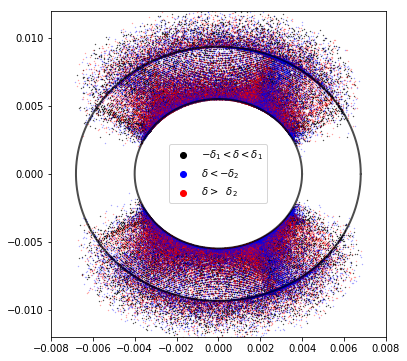

In [214]:
plt.figure(figsize=(6,6))
plt.plot(ap0_x*c,ap0_y*s,alpha=0.7,c='k',lw=2)
plt.plot(ap1_x*c,ap1_y*s,alpha=0.7,c='k',lw=2)
plt.scatter(data['pLost'][pLostIndex[ 2],1],data['pLost'][pLostIndex[ 2],2],s=0.1,color='k')
plt.scatter(data['pLost'][pLostIndex[ 0],1],data['pLost'][pLostIndex[ 0],2],s=0.1,color='b',alpha=0.25)
plt.scatter(data['pLost'][pLostIndex[ 4],1],data['pLost'][pLostIndex[ 4],2],s=0.1,color='r',alpha=0.5)
plt.scatter(data['pLost'][pLostIndex[ 0],1],data['pLost'][pLostIndex[ 0],2],s=0.1,color='b',alpha=0.25)
p0 = plt.scatter(1,1,color='k')
p1 = plt.scatter(1,1,color='b')
p2 = plt.scatter(1,1,color='r')
plt.legend([p0,p1,p2],
           ['$-\delta_1 < \delta < \delta_1$',
            '$\delta < -\delta_2$',
            '$\delta > \,\,\,\,\delta_2$']);
# plt.scatter(data['pLost'][pLostIndex[ 4],1],data['pLost'][pLostIndex[ 4],2],s=0.1,color='C2')
plt.xlim(-0.008,0.008)
plt.ylim(-0.012,0.012)

In [35]:
data['Twiss1']

(0.4950004867198259,
 0.16680372901162024,
 2.6319224543354984e-06,
 2.038761149901226,
 0.46375944365876637,
 5.581257004298362e-06,
 1337.4131359674682,
 2.351477820431212,
 0.005120039012198388)

In [36]:
data['Twiss0']

(1.5039934601231633,
 1.0923962161401128,
 2.591792346497486e-06,
 3.2509078231896473,
 2.36443754289077,
 5.580037044319971e-06,
 199.77315813090397,
 0.0015518716934145198,
 0.004993674591276034)

### Exponential, $H_{\tau=0.4}$, $\sigma_E=2\times10^{-3}$, $order=3$

In [21]:
prepare_Exponential(0.4950004867198259,0.16680372901162024,emitGeomRMS,6.0,
                    2.038761149901226, 0.46375944365876637,emitGeomRMS,6.0,
                    2.0e-3,0.4,0.4,order=3)

0

data = get_Exponential_data([0,8500,9000,10000],0.4,0.4)

plt.plot(data['pData1'][:,-1])

data['pLost'][:,-1].max()